# Deep Learning - Exercise 8

The aim of this exercise is to learn how to implement and utilize attention mechanisms in deep learning models, focusing on how these techniques allow models to selectively focus on the most relevant parts of input data.

**Core Concepts**
* 🧠 Attention mechanism fundamentals and mathematical foundations
* 🔍 Types of attention mechanisms (Self-attention, Dot-product)
* 📊 Applications in natural language processing
* ⚙️ Implementation of attention-based models

We recommend reading [this post](https://analyticsindiamag.com/a-beginners-guide-to-using-attention-layer-in-neural-networks/) for more detailed information.

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_08.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_08.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Layer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import os

# from keract import get_activations
from keras import Input, Model
from tensorflow.keras.callbacks import Callback
import keras.backend as K
from tensorflow.keras import layers

os.environ['KERAS_ATTENTION_DEBUG'] = '1'
from attention import Attention

plt.rcParams.update({'font.size': 8})

keras.utils.set_random_seed(13)
tf.version.VERSION

2025-04-08 18:25:53.396954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744129553.412086   43482 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744129553.416048   43482 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 18:25:53.429737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.18.0'

In [2]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# 📒 What is the Attention mechanism?

* When we think about the English word **Attention**, we know that it means **directing your focus at something** and taking greater notice
* The Attention mechanism in Deep Learning is based off this concept of directing your focus, and it pays greater attention to certain factors when processing the data
    * 📌 Paying attention to important information is necessary and it can improve the performance of the model
* **Attention mechanism can help a neural network to memorize long sequences of the information**
    * 🔎 Remember the RNN and even LSTM long-context issues?
* 🔎 Can you imagine some use-cases where it can help us?

> 💡 In very simple terms the Attention mechanism makes sure that the forget mechanism of LSTM layers is not applied over the important pieces of information

### The process is usually computed in these few steps

![Img00](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_04.png?raw=true)

* Let’s say that we have an input with n sequences and output y with m sequence in a network
    * $x=[x_1, x_2, ..., x_n]$
    * $y = [y_1, y_2, ..., y_n]$
    
* The encoder which we are using in the network is a bidirectional LSTM network where it has a forward hidden state and a backward hidden state
    * Representation of the encoder state can be done by concatenation of these forward and backward states
    * $h_i = [h_i^{L2R}, h_i^{R2L}]$

* The hidden state is:
    * $s_t=f(s_{t-1}, y_{t-1}, c_t)$
    
* For the output word at position t, the context vector $C_t$ can be the sum of the hidden states of the input sequence
* Thus we have:

![Img02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_02.png?raw=true)

* Here we can see that the sum of the hidden state is weighted by the alignment scores
* 💡 We can say that ${\alpha_{t,i}}$  are the weights that are responsible for defining how much of each source’s hidden state should be taken into consideration for each output

* 💡 There can be various types of alignment scores according to their geometry
    * It can be either linear or in the curve geometry

### 📌 Below are some of the popular attention mechanisms:

![Img03](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_03.png?raw=true)

#### 💡 There are many variants of the mechanism in the wild but the basic computation process is the same

### The very common and easy to understand example is **Self-Attention Mechanism**
* When an attention mechanism is applied to the network so that it can relate to different positions of a single sequence and can compute the representation of the same sequence, it can be considered as self-attention

![Img01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_01.png?raw=true)

* Here in the image, the red color represents the word which is currently learning and the blue color is of the memory, and the intensity of the color represents the degree of memory activation

## ⚡ We will use Attention layer from the library first and try to solve the *Find-Max task*
* What is the *Find-Max* task?

In [ ]:
def generate_data(num_samples, seq_length):
    X = np.random.uniform(0, 10, (num_samples, seq_length, 1))
    y = np.max(X, axis=1)  # Find maximum value in each sequence
    return X, y

seq_length = 15
# Generate 10,000 sequences of length 15
X_train, y_train = generate_data(10000, seq_length)
X_test, y_test = generate_data(1000, seq_length)

## ⚡ We will employ a simple LSTM-based model with attention layer stacked to it
* 🔎 What is the intuition behind using attention?

In [4]:
inputs = Input(shape=(seq_length, 1))
x = LSTM(64, return_sequences=True)(inputs)
x = Attention(units=32)(x)  # Bahdanau-style additive attention
outputs = Dense(1)(x)
model = Model(inputs, outputs)
model.compile(loss='mse', optimizer='adam')
model.summary()

I0000 00:00:1744129555.413177   43482 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 15, 64)    │     16,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_hidden_state   │ (None, 64)        │          0 │ lstm[0][0]        │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ luong_w (Dense)     │ (None, 15, 64)    │      4,096 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_score     │ (None, 15)        │          0 │ last_hidden_stat… │
│ (Dot)               │                   │            │ luong_w[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 15)        │          0 │ attention_score[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 64)        │          0 │ lstm[0][0],       │
│ (Dot)               │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_output    │ (None, 128)       │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ last_hidden_stat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vector    │ (None, 32)        │      4,096 │ attention_output… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         33 │ attention_vector… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,121 (98.13 KB)

 Trainable params: 25,121 (98.13 KB)

 Non-trainable params: 0 (0.00 B)

## We want to access the attention weights so we need to create a custom model to access it

In [5]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <LSTM name=lstm, built=True>,
 <Lambda name=last_hidden_state, built=True>,
 <Dense name=luong_w, built=True>,
 <Dot name=attention_score, built=True>,
 <Activation name=attention_weight, built=True>,
 <Dot name=context_vector, built=True>,
 <Concatenate name=attention_output, built=True>,
 <Dense name=attention_vector, built=True>,
 <Dense name=dense, built=True>]

In [6]:
visualization_model = Model(
    inputs=inputs,
    outputs=[model.layers[-1].output, model.layers[4].output]  # Access attention layer
)

# 🚀 Let's train the model

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32
)

Epoch 1/40


I0000 00:00:1744129558.178973   43540 cuda_dnn.cc:529] Loaded cuDNN version 90501


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 11.8575 - val_loss: 0.3338
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.3584 - val_loss: 0.3193
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.3295 - val_loss: 0.2848
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2849 - val_loss: 0.2811
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2222 - val_loss: 0.1832
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1368 - val_loss: 0.0797
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0679 - val_loss: 0.0357
Epoch 8/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0319 - val_loss: 0.0179
Epoch 9/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0214 - val_loss: 0.0142
Epoch 10/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0167 - val_loss: 0.0118
Epoch 11/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0133 - val_loss: 0.0099
Epoch 12/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/st

## Now we can predict the values for the testing set

In [8]:
preds = model.predict(X_test)
preds.ravel()[:10], y_test.ravel()[:10]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(array([9.927576 , 9.146368 , 9.654835 , 9.028513 , 9.832987 , 9.352687 ,
        7.9908576, 9.410795 , 9.855614 , 9.316517 ], dtype=float32),
 array([9.87880117, 9.10068569, 9.63193881, 8.89109298, 9.7829609 ,
        9.32795348, 7.99399699, 9.34653919, 9.75892522, 9.29271441]))

## 💡 How should the predicted vs. true values scatter plot look like?

<Axes: >

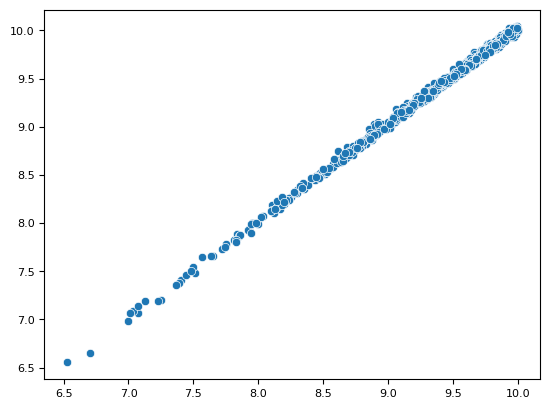

In [9]:
sns.scatterplot(x=y_test.ravel(), y=preds.ravel())

In [10]:
# Test with sample sequence
prediction_arr, attention_weights_arr = [], []
for i in range(12):
    prediction, attention_weights = visualization_model.predict(X_test[i])
    prediction_arr.append(prediction)
    attention_weights_arr.append(attention_weights)
# prediction, attention_weights = visualization_model.predict(X_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/home/vojte/.virtualenvs/hluboke-uceni/lib/python3.12/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (15, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


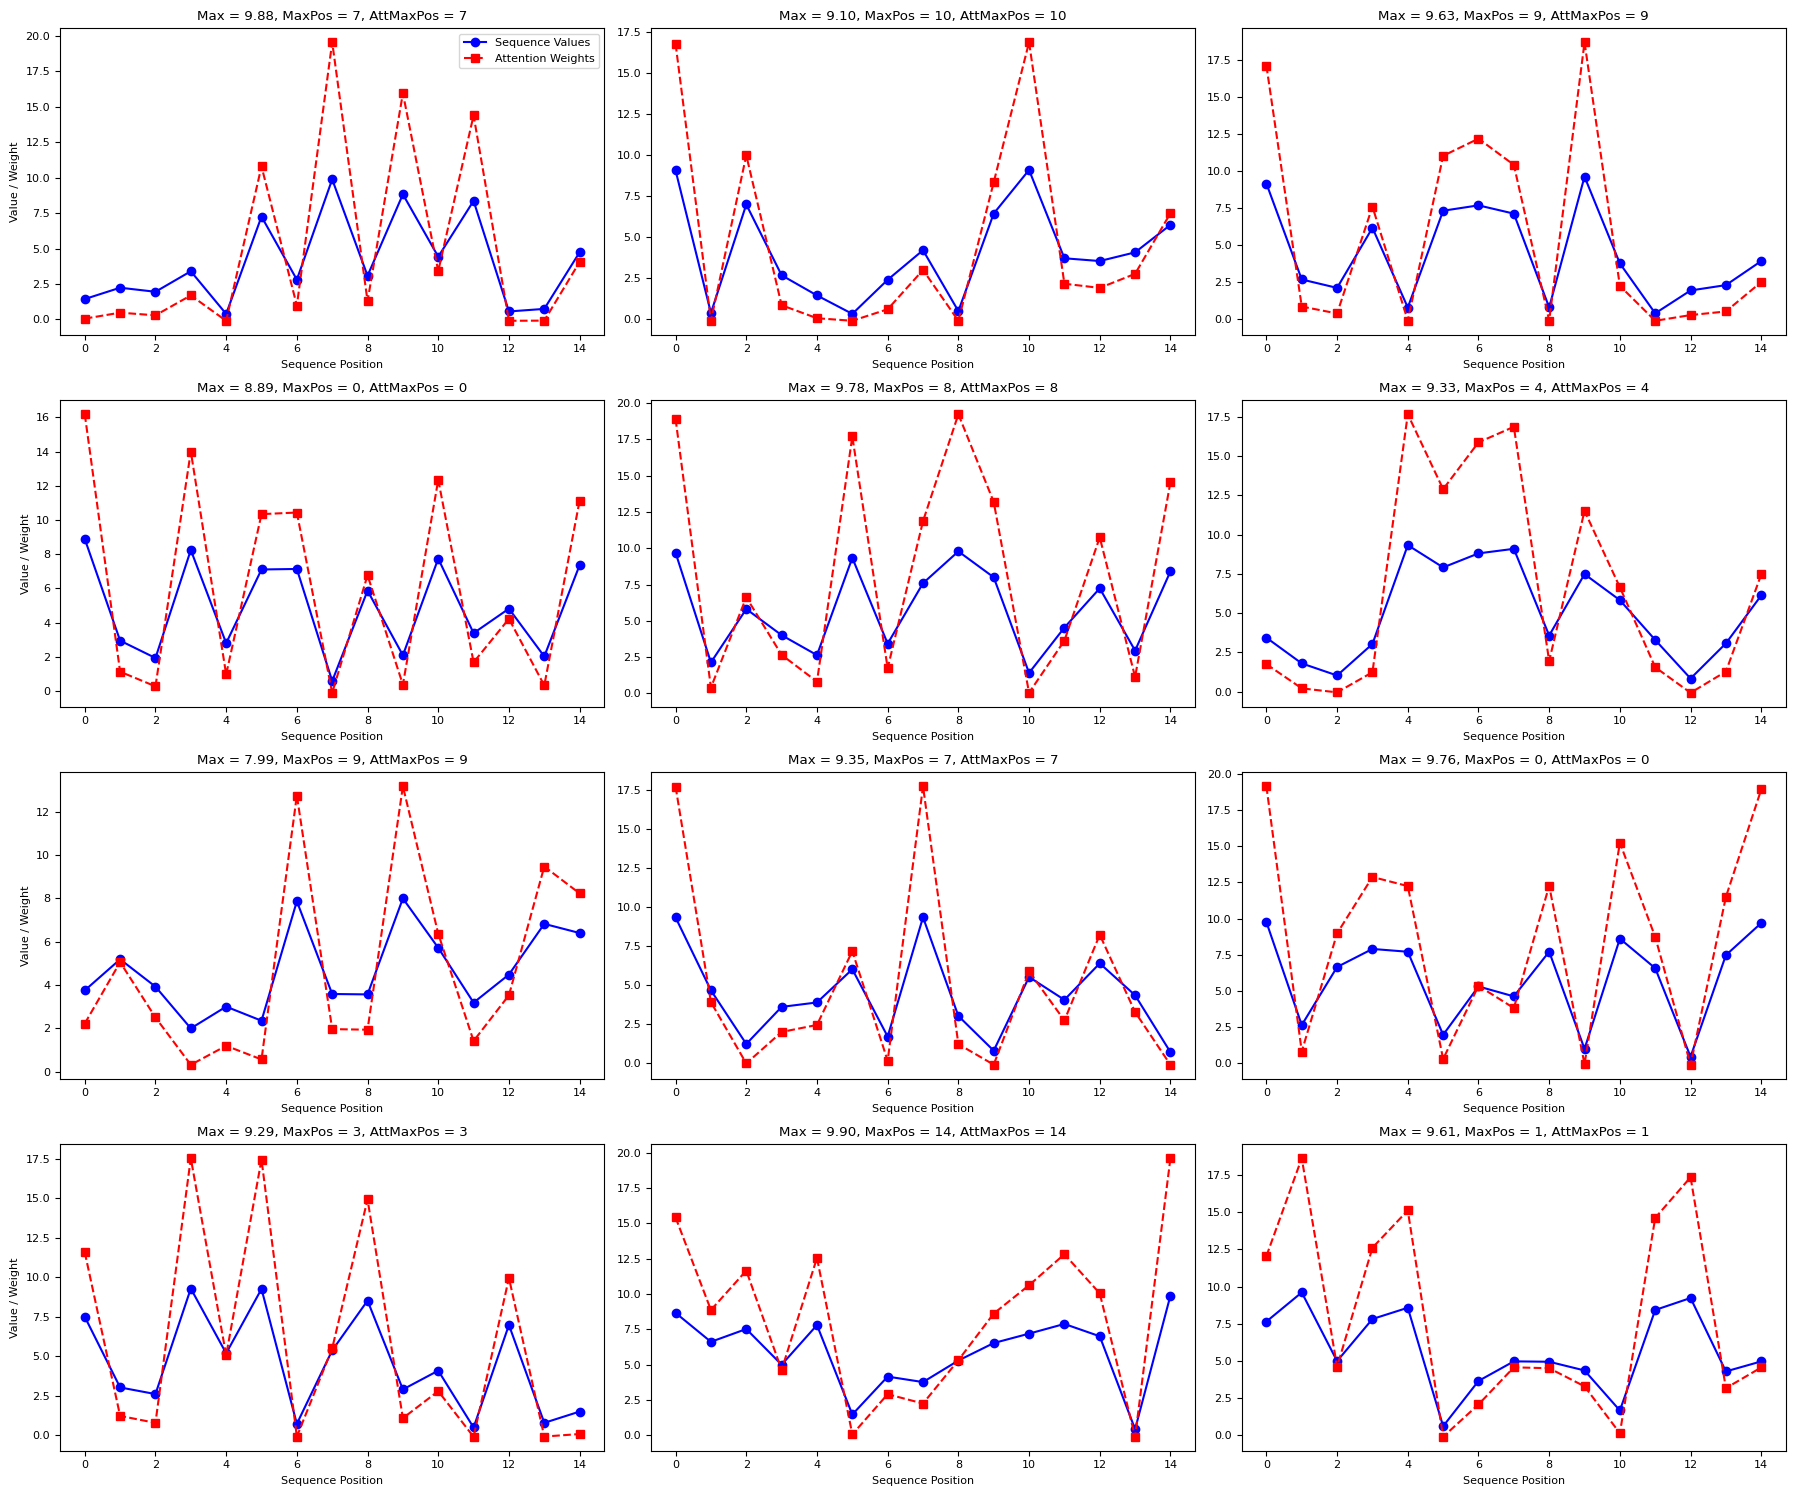

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(4, 3)

for i in range(12):
    ax = plt.subplot(gs[i//3, i%3])
    ax.plot(X_test[i], 'b-o', label='Sequence Values')
    ax.plot(attention_weights_arr[i], 'r--s', label='Attention Weights')
    ax.set_title(f'Max = {y_test[i][0]:.2f}, MaxPos = {np.argmax(X_test[i])}, AttMaxPos = {np.argmax(attention_weights_arr[i])}')
    ax.set_xlabel('Sequence Position')
    if i % 3 == 0:
        ax.set_ylabel('Value / Weight')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## ⚡ Now as we know how the Attention layer works we can employ it for the sentiment analysis task
* We will use Yelp dataset which contains reviews of restaurants with either positive (1) or negative (0) labels assigned

## Download and load the dataset

In [ ]:
path_to_file = tf.keras.utils.get_file('yelp_labelled.txt', 'https://raw.githubusercontent.com/rasvob/VSB-FEI-Deep-Learning-Exercises/main/datasets/yelp_labelled.txt')

In [13]:
path_to_file

'/home/vojte/.keras/datasets/yelp_labelled.txt'

In [14]:
with open(path_to_file) as f:
    lines = f.readlines()
    lines = [x.rstrip() for x in lines]

In [15]:
len(lines)

3000

In [16]:
lines_dict = [{'Text': x[:-1].rstrip(), 'Label': int(x[-1])} for x in lines]

In [17]:
df = pd.DataFrame.from_dict(lines_dict)

In [18]:
df.head()

,Text,Label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### ⚡ We will use TextVectorization layer as usuall and we will create baseline model without the Attention layer first

In [ ]:
embedding_dim = 64 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
max_tokens = 3000
sequence_length = 32 # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Text.values)

In [20]:
vocab = vect_layer.get_vocabulary()

##  The dataset is balanced
* 💡 We will use `stratify` parameter of the `train_test_split` to make sure that it stays balanced

In [21]:
df.Label.value_counts()

Label
1    1500
0    1500
Name: count, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.Text, df.Label, test_size=0.20, random_state=13, stratify=df.Label)

In [23]:
print(X_train.shape, X_test.shape)

(2400,) (600,)


In [24]:
print('Train')
print(y_train.value_counts())
print('Test')
print(y_test.value_counts())

Train
Label
0    1200
1    1200
Name: count, dtype: int64
Test
Label
0    300
1    300
Name: count, dtype: int64


## Let's define very simple model first

This LSTM layer processes sequential data from the preceding embedding layer (`emb`), generates a 50-dimensional output vector, and applies two types of dropout regularization to combat overfitting


### Key Components of LSTM
1. **Units (50)**  
   - The LSTM layer contains 50 memory cells, each capable of learning long-term dependencies in sequential data
   - The final output (`x`) is a 50-dimensional vector summarizing the sequence’s contextual information

2. **Dropout (0.3)**  
   - **Input Dropout**: Randomly drops 30% of input units during training to prevent overfitting
   - Example: If the embedding layer outputs 300-dimensional vectors, 90 features (30% of 300) are masked in each training step

3. **Recurrent Dropout (0.4)**  
   - Drops 40% of the recurrent connections (hidden state transitions between timesteps) during training
   - This specifically regularizes the LSTM’s internal memory mechanisms

In [25]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(len(vocab), output_dim=embedding_dim, embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
x = LSTM(50, dropout=0.3, recurrent_dropout=0.4)(emb)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.AdamW(), loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=[keras.metrics.BinaryAccuracy()])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 32)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 32, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,051 (840.04 KB)

 Trainable params: 215,051 (840.04 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - binary_accuracy: 0.4763 - loss: 0.8240 - val_binary_accuracy: 0.5042 - val_loss: 0.7517
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - binary_accuracy: 0.4889 - loss: 0.7388 - val_binary_accuracy: 0.5375 - val_loss: 0.7094
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - binary_accuracy: 0.5394 - loss: 0.7045 - val_binary_accuracy: 0.5083 - val_loss: 0.6964
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - binary_accuracy: 0.4878 - loss: 0.6960 - val_binary_accuracy: 0.4938 - val_loss: 0.6939
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - binary_accuracy: 0.5030 - loss: 0.6934 - val_binary_accuracy: 0.4958 - val_loss: 0.6937
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - binary_accuracy: 0.5188 - loss: 0.6933 - val_binary_accuracy: 0.5667 - val_loss: 0.6931
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - binary_accuracy: 0.5630 - loss: 0.6862 - val_binary_accuracy: 0.5437 - val_loss: 0.6823
Epoch 

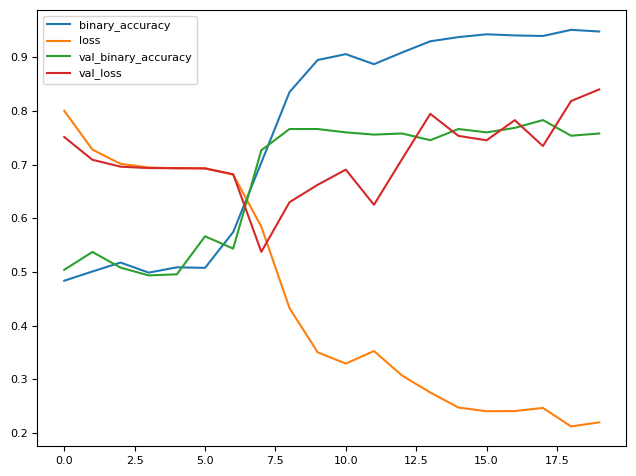

In [27]:
batch_size = 128
epochs = 20

history = model.fit(X_train.values, y_train.values, validation_split=0.2, callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [28]:
test_loss, test_acc = model.evaluate(X_test.values, y_test.values)
test_acc

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.7699 - loss: 0.8134


0.7766666412353516

# Now we will create our own Attention layer and add it to the model

![meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_meme_01.jpg?raw=true)



In [ ]:
class MyAttention(Layer):
    def __init__(self, **kwargs):
        super(MyAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(MyAttention, self).build(input_shape)

    def call(self, x):
        dot = tf.matmul(x, self.W) + self.b
        th = tf.math.tanh(dot)
        et = tf.squeeze(th, axis=-1) # Remove last dimension, similar to np.squeeze
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1) # Add last dimension, similar to np.expand_dims
        output = x * at
        res = tf.reduce_sum(output, axis=1) # Sum along the sequence length
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(MyAttention, self).get_config()


## 💡 The shapes for our layer will look like this:
* input (None, 32, 128) W: (128, 1) b: (32, 1)
* dot (None, 32, 1)
* th (None, 32, 1)
* squeeze (None, 32)
* softmax (None, 32)
* expand_dims (None, 32, 1)
* output (None, 32, 128)
* res (None, 128)

### 🔎 Why do we have `32` biases and `128` weights?

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(len(vocab), output_dim=embedding_dim, embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
x = LSTM(128, dropout=0.3,recurrent_dropout=0.2, return_sequences=True)(emb)
x = MyAttention()(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.AdamW(), loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=[keras.metrics.BinaryAccuracy()])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 32)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 32, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_attention (MyAttention)      │ (None, 128)            │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,105 (1.11 MB)

 Trainable params: 291,105 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - binary_accuracy: 0.5054 - loss: 0.7741 - val_binary_accuracy: 0.4958 - val_loss: 0.6950
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - binary_accuracy: 0.5349 - loss: 0.6876 - val_binary_accuracy: 0.7063 - val_loss: 0.5921
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 246ms/step - binary_accuracy: 0.7811 - loss: 0.4945 - val_binary_accuracy: 0.7479 - val_loss: 0.5960
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - binary_accuracy: 0.8917 - loss: 0.3453 - val_binary_accuracy: 0.7604 - val_loss: 0.5522
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - binary_accuracy: 0.9309 - loss: 0.2561 - val_binary_accuracy: 0.7479 - val_loss: 0.7911
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - binary_accuracy: 0.9250 - loss: 0.2575 - val_binary_accuracy: 0.7604 - val_loss: 0.6812
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - binary_accuracy: 0.9523 - loss: 0.2052 - val_binary_accuracy: 0.7396 - val_loss: 0.8494

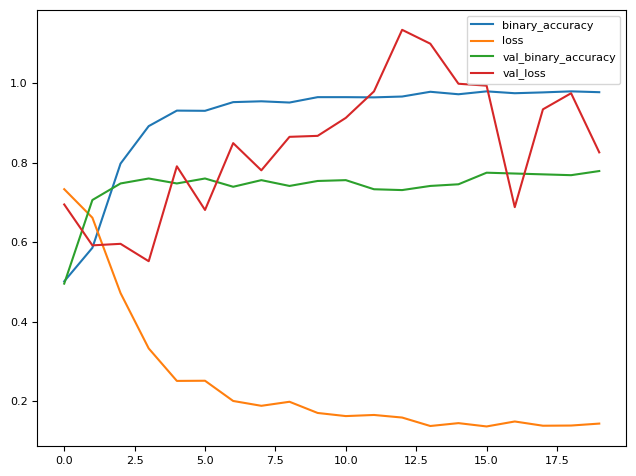

In [ ]:
batch_size = 32
epochs = 20

history = model.fit(X_train.values, y_train.values, validation_split=0.2, callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [33]:
test_loss, test_acc = model.evaluate(X_test.values, y_test.values)
test_acc

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - binary_accuracy: 0.7398 - loss: 0.9421


0.753333330154419

# ✅  Tasks for the lecture (2p)

* `Attention` layer from the [library](https://github.com/philipperemy/keras-attention) has 2 `score` variants (1p)
    * Use the layer in your model and test both `score` variants
    * Is there any difference in the performance?

* It is possible to make LSTM/GRU layers `Bidirectional` using the [Bidirectional layer
](https://keras.io/api/layers/recurrent_layers/bidirectional/) (1p)
    * Use it in your model - what happened to the number of weights? Was there any improvement?

## Task 1

In [34]:
import attention

### Luong

In [ ]:
inputs = Input(shape=(1,), dtype=tf_string)  # Note: shape needs to match original model
x_v = vect_layer(inputs)
emb = keras.layers.Embedding(len(vocab), output_dim=embedding_dim, embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
x = LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(emb)
x = attention.Attention(score='luong')(x)
outputs = keras.layers.Dense(1, 'sigmoid')(x)
model_luong = keras.Model(inputs, outputs)
model_luong.compile(optimizer=keras.optimizers.AdamW(),
                 loss=keras.losses.BinaryCrossentropy(from_logits=False),
                 metrics=[keras.metrics.BinaryAccuracy()])

print("Model with 'luong' score attention:")
model_luong.summary()

Model with 'luong' score attention:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 32)        │          0 │ input_layer_3[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 32, 64)    │    192,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32, 128)   │     98,816 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_hidden_state   │ (None, 128)       │          0 │ lstm_3[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ luong_w (Dense)     │ (None, 32, 128)   │     16,384 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_score     │ (None, 32)        │          0 │ last_hidden_stat… │
│ (Dot)               │                   │            │ luong_w[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 32)        │          0 │ attention_score[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 128)       │          0 │ lstm_3[0][0],     │
│ (Dot)               │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_output    │ (None, 256)       │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ last_hidden_stat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vector    │ (None, 128)       │     32,768 │ attention_output… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ attention_vector… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 340,097 (1.30 MB)

 Trainable params: 340,097 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_luong = model_luong.fit(X_train.values, y_train.values,
                          validation_split=0.2,
                          epochs=20,
                          batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - binary_accuracy: 0.5211 - loss: 0.7748 - val_binary_accuracy: 0.4958 - val_loss: 0.6914
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - binary_accuracy: 0.6258 - loss: 0.6536 - val_binary_accuracy: 0.7437 - val_loss: 0.5261
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - binary_accuracy: 0.8433 - loss: 0.4114 - val_binary_accuracy: 0.7729 - val_loss: 0.5142
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 237ms/step - binary_accuracy: 0.9112 - loss: 0.2820 - val_binary_accuracy: 0.7729 - val_loss: 0.6108
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - binary_accuracy: 0.9466 - loss: 0.2094 - val_binary_accuracy: 0.7812 - val_loss: 0.6600
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step - binary_accuracy: 0.9556 - loss: 0.1755 - val_binary_accuracy: 0.7708 - val_loss: 0.7391
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - binary_accuracy: 0.9504 - loss: 0.1708 - val_binary_accuracy: 0.7812 - val_loss: 0.9167

In [37]:
test_loss_luong, test_acc_luong = model_luong.evaluate(X_test.values, y_test.values)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - binary_accuracy: 0.7744 - loss: 1.2243


### Bahdanau

In [ ]:
inputs = Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(inputs)
emb = keras.layers.Embedding(len(vocab), output_dim=embedding_dim, embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
lstm_outputs = LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(emb)

context_vector = Attention()(lstm_outputs)
outputs = keras.layers.Dense(1, 'sigmoid')(context_vector)

model_bahdanau = keras.Model(inputs, outputs)
model_bahdanau.compile(optimizer=keras.optimizers.AdamW(),
                    loss=keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics=[keras.metrics.BinaryAccuracy()])

print("Model with imported Attention layer:")
model_bahdanau.summary()

Model with imported Attention layer:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 32)        │          0 │ input_layer_4[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 32, 64)    │    192,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 32, 128)   │     98,816 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_hidden_state   │ (None, 128)       │          0 │ lstm_4[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ luong_w (Dense)     │ (None, 32, 128)   │     16,384 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_score     │ (None, 32)        │          0 │ last_hidden_stat… │
│ (Dot)               │                   │            │ luong_w[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 32)        │          0 │ attention_score[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 128)       │          0 │ lstm_4[0][0],     │
│ (Dot)               │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_output    │ (None, 256)       │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ last_hidden_stat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vector    │ (None, 128)       │     32,768 │ attention_output… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        129 │ attention_vector… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 340,097 (1.30 MB)

 Trainable params: 340,097 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_bahdanau = model_bahdanau.fit(X_train.values, y_train.values,
                                  validation_split=0.2,
                                  epochs=epochs,
                                  batch_size=batch_size)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - binary_accuracy: 0.5132 - loss: 0.7746 - val_binary_accuracy: 0.4958 - val_loss: 0.6956
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - binary_accuracy: 0.5873 - loss: 0.6718 - val_binary_accuracy: 0.7458 - val_loss: 0.5341
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step - binary_accuracy: 0.8176 - loss: 0.4552 - val_binary_accuracy: 0.7750 - val_loss: 0.5000
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - binary_accuracy: 0.9029 - loss: 0.3060 - val_binary_accuracy: 0.7500 - val_loss: 0.7186
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - binary_accuracy: 0.9400 - loss: 0.2293 - val_binary_accuracy: 0.7521 - val_loss: 0.6532
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - binary_accuracy: 0.9322 - loss: 0.2232 - val_binary_accuracy: 0.7708 - val_loss: 0.7333
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - binary_accuracy: 0.9616 - loss: 0.1630 - val_binary_accuracy: 0.7750 - val_loss: 0.7786

In [40]:
test_loss_bahdanau, test_acc_bahdanau = model_bahdanau.evaluate(X_test.values, y_test.values)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - binary_accuracy: 0.7773 - loss: 1.0143


### Results

In [41]:
print(f"Test Accuracy ('Luong' score): {test_acc_luong:.4f}")
print(f"Test Accuracy ('Bahdanau' score): {test_acc_bahdanau:.4f}")

Test Accuracy ('Luong' score): 0.7833
Test Accuracy ('Bahdanau' score): 0.7900


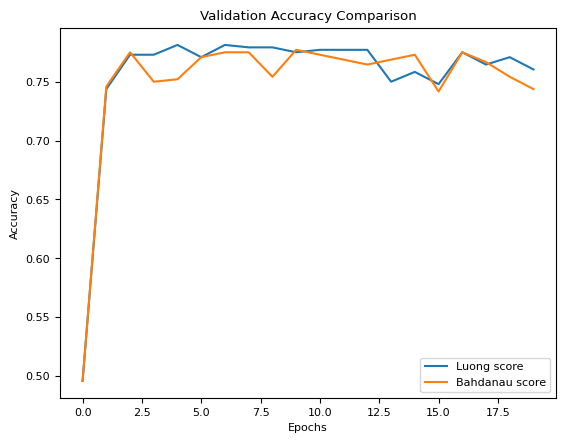

In [43]:
plt.figure()
plt.plot(history_luong.history['val_binary_accuracy'], label='Luong score')
plt.plot(history_bahdanau.history['val_binary_accuracy'], label='Bahdanau score')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Summary
Key Findings:
- **Bahdanau** *(0.7900)* slightly outperformed **Luong** *(0.7833)* by **0.67%**.
- Both achieved *solid* accuracy.

Why the Difference?
- **Bahdanau** *(Additive)* 🧮: Uses a feed-forward net for attention scores; better at capturing complex word relationships.
- **Luong** *(Multiplicative)* 🔢: Uses dot-product scoring; faster but less expressive.

## Task 2

### Bidirectional LSTM

In [ ]:
inputs = Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(inputs)
emb = keras.layers.Embedding(len(vocab), output_dim=embedding_dim, embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
x = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))(emb)
x = MyAttention()(x)
outputs = keras.layers.Dense(1, 'sigmoid')(x)

bidirectional_model = keras.Model(inputs, outputs)
bidirectional_model.compile(optimizer=keras.optimizers.AdamW(), 
                        loss=keras.losses.BinaryCrossentropy(from_logits=False), 
                        metrics=[keras.metrics.BinaryAccuracy()])

print("Model with Bidirectional LSTM:")
bidirectional_model.summary()

Model with Bidirectional LSTM:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 32)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 32, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_attention_1 (MyAttention)    │ (None, 256)            │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,177 (1.49 MB)

 Trainable params: 390,177 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_bidirectional = bidirectional_model.fit(X_train.values, y_train.values,
                                     validation_split=0.2,
                                     epochs=epochs,
                                     batch_size=batch_size)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 514ms/step - binary_accuracy: 0.5060 - loss: 0.7742 - val_binary_accuracy: 0.4958 - val_loss: 0.6955
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 507ms/step - binary_accuracy: 0.5188 - loss: 0.6926 - val_binary_accuracy: 0.6229 - val_loss: 0.6490
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - binary_accuracy: 0.6971 - loss: 0.5747 - val_binary_accuracy: 0.7333 - val_loss: 0.5655
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 491ms/step - binary_accuracy: 0.8801 - loss: 0.3481 - val_binary_accuracy: 0.7479 - val_loss: 0.6998
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 504ms/step - binary_accuracy: 0.9251 - loss: 0.2705 - val_binary_accuracy: 0.7771 - val_loss: 0.5630
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 488ms/step - binary_accuracy: 0.9403 - loss: 0.2264 - val_binary_accuracy: 0.7708 - val_loss: 0.6264
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 510ms/step - binary_accuracy: 0.9442 - loss: 0.2253 - val_binary_accuracy: 0.7563 - val_loss: 0.7113

In [ ]:
test_loss_bidirectional, test_acc_bidirectional = bidirectional_model.evaluate(X_test.values, y_test.values)
print(f"Test Accuracy (Bidirectional LSTM): {test_acc_bidirectional:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - binary_accuracy: 0.7862 - loss: 0.8835
Test Accuracy (Bidirectional LSTM): 0.7900


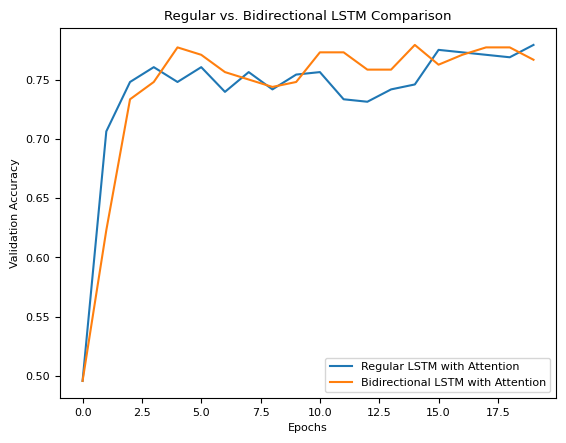

In [ ]:
plt.figure()
plt.plot(history.history['val_binary_accuracy'], label='Regular LSTM with Attention')
plt.plot(history_bidirectional.history['val_binary_accuracy'], label='Bidirectional LSTM with Attention')
plt.title('Regular vs. Bidirectional LSTM Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

### Analysis of the models

In [ ]:
print("\nModel Comparison Results:")
print(f"Regular LSTM Test Accuracy: {test_acc:.4f}")
print(f"Bidirectional LSTM Test Accuracy: {test_acc_bidirectional:.4f}")
print(f"Improvement: {(test_acc_bidirectional - test_acc) * 100:.2f}%")

# this is hardcoded, for future measurement, use time module
lstm_time_seconds = 4*60*60 + 59*60 + 58  # 4:59:58 converted to seconds
bidirectional_time_seconds = 10*60*60 + 35*60 + 1  # 10:35:01 converted to seconds
time_ratio = bidirectional_time_seconds / lstm_time_seconds

print(f"Time taken for training Regular LSTM: 4:59:58")
print(f"Time taken for training Bidirectional LSTM: 10:35:01")
print(f"Time ratio: Bidirectional takes {time_ratio:.2f}x longer than Regular LSTM")


Model Comparison Results:
Regular LSTM Test Accuracy: 0.7533
Bidirectional LSTM Test Accuracy: 0.7900
Improvement: 3.67%
Time taken for training Regular LSTM: 4:59:58
Time taken for training Bidirectional LSTM: 10:35:01
Time ratio: Bidirectional takes 2.12x longer than Regular LSTM


In [ ]:
regular_params = model.count_params()
bidirectional_params = bidirectional_model.count_params()
print(f"\nParameter Analysis:")
print(f"Regular LSTM parameter count: {regular_params:,}")
print(f"Bidirectional LSTM parameter count: {bidirectional_params:,}")
print(f"Increase in parameters: {(bidirectional_params - regular_params):,} ({(bidirectional_params/regular_params - 1) * 100:.2f}%)")

## Why Bidirectional LSTM has more parameters:

A Bidirectional LSTM processes input sequences in both forward and backward directions, effectively doubling the number of LSTM units:
- **Regular LSTM**: 128 units in one direction = 291,105 parameters
- **Bidirectional LSTM**: 128 × 2 directions = 256 total units = 390,177 parameters

This nearly doubles the parameter count (+99,072 or +34.03%) while providing the following benefits:
- Captures context from both past and future time steps ⬅️➡️
- Provides richer representations that understand complete contextual information 🧠
- Increases model accuracy by 3.67% (from 75.33% to 79.00%) 📈